# Introduction to Deep Learning

### Hands-on 2b: Generative (Autoregressive) Models 
Filippo Vicentini and Giuseppe Carleo

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/21como-intro-to-deeplearning/2b-generative.ipynb) 

#### Link to the GitHub repository:
https://github.com/PhilipVinc/IntroDeepLearning

or 

https://bit.ly/3ki90ki

-------------

The objective of this hands-on is to write and optimise a generative model that learns how handwritten digits from MNIST are 'made' of, and can generate images that look like them.
Also, that if there are parts of an image that are missing, complete it in a believable fashion.

We will use again the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/)


## 0 - Install Requirements

For this example notebook we will need jax+flax+optax for the machine-learning part.

For the dataset, instead, we will be using `tensorflow_datasets`, which is a submodule of `tensorflow` that makes it easy to download and load into memory large datasets (such as MNIST and many others).

if you are on colab you also need to download a file with some handy utility methods to plot images.

If you are running notebook locally, you need to also install `tensorflow` to make `tensorflow_datasets` work.

In [1]:
# Requirement packages and utility methods
#!pip install tensorflow_datasets flax jax optax tqdm
#!wget https://raw.githubusercontent.com/PhilipVinc/IntroDeepLearning/master/vae_utils_2.py

## 1 - Import packages

Here I import all the packages that we will need in this notebook (hopefully).

In [2]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

from flax import linen as nn
from flax.training import train_state

import optax

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import tqdm

# Some handy utilities.
# You must download them with wget on colab
import vae_utils_2 as vae_utils


## 1 - (Dense) Autoregressive Network

We want to write a generative model with the property that:

$$
p(\vec{x}) = p(x_1) p (x_2 | x_1) p(x_3|x_2,x_1) \dots p(x_N | x_{N-1}, \dots, x_1)
$$

this can be achieved by using a so-called *masked dense layer

$$
p_i(\vec{x}) = \sum_{i<j} W_{i,j} x_j = \sum_{i, j} \tilde{W}_{i,j} x_j
$$

where $\tilde{W}_{i,j} = 0 $ if $i >= j$.

We therefore want to write down a simple *Masked Dense Layer* behaving similar to a Flax's dense layer.

In [3]:
# We define it using Flax.linen module
class MaskedDense1D(nn.Module):
    """1D linear transformation module with mask for autoregressive Neural Network."""

    features: int
    """number of output features, should be the last dimension."""
    exclusive: bool
    """True if an output element does not depend on the input element at the same index."""
    dtype = jnp.float32
    """the dtype of the computation (default: float64)."""
    kernel_init = nn.initializers.lecun_normal()
    """initializer for the weight matrix."""
    bias_init  = nn.initializers.zeros
    """initializer for the bias."""

    @nn.compact
    def __call__(self, inputs):
        """
        Applies a masked linear transformation to the inputs.
        
        Args:
          inputs: input data with dimensions (batch, length, features).
        Returns:
          The transformed data.
        """
        # compute the dtype to be used throught the calculations
        dtype = jnp.promote_types(inputs.dtype, self.dtype)

        inputs = jnp.asarray(inputs, dtype)

        # Make sure the input has 3-dimensions
        is_single_input = False
        if inputs.ndim == 2:
            is_single_input = True
            inputs = jnp.expand_dims(inputs, axis=0)

        # Reshape the input to concatenate size and features in the same
        # array dimension
        batch, size, in_features = inputs.shape
        inputs = inputs.reshape((batch, size * in_features))

        # Create a mask to enforce the requirement W_{i,j}=0 if i>j 
        mask = jnp.ones((size, size), dtype=self.dtype)
        mask = jnp.triu(mask, self.exclusive)
        mask = jnp.kron(mask, jnp.ones((in_features, self.features), dtype=self.dtype))
    
        # apply the mask to the initializer of the kernel matrix
        # and correct the variance to account for the elements that
        # are zero
        """Correction to LeCun normal init."""
        corr = jnp.sqrt(mask.size / mask.sum())

        def masked_kernel_init(*args):
            # see that 
            return corr * mask * self.kernel_init(*args)

        # Create the kernel matrix using the masked initializer
        # The kernel will be stored with dtype=self.dtype
        kernel = self.param(
            "kernel",
            masked_kernel_init,  # initializer
            (size * in_features, size * self.features),  # shape
            self.dtype, # use self.dtype for the data type of the kernel
        )
        
        # Convert the mask and the kernel *at runtime* to the correct
        # dtype that matches the inputs. Most of the time this does
        # nothing, but sometimes it can avoid some bugs.
        mask = jnp.asarray(mask, dtype)
        kernel = jnp.asarray(kernel, dtype)
    
        # y_i = W_i,j x_j
        y = lax.dot(inputs, mask * kernel)
        
        # Reshape again to extract the feature dimensions
        y = y.reshape((batch, size, self.features))
        
        # add a bias.
        bias = self.param("bias", self.bias_init, (size, self.features), self.dtype)
        bias = jnp.asarray(bias, dtype)
        y = y + bias

        # if we had only one sample, remove the batch dimension
        if is_single_input:
            y = y.squeeze(axis=0)

        return y


Now that we have defined the Masked layer, let's use two masked layers to create an autoregressive neural network.

We need to be carefull on how we set the `exclusive` property of the two layers.

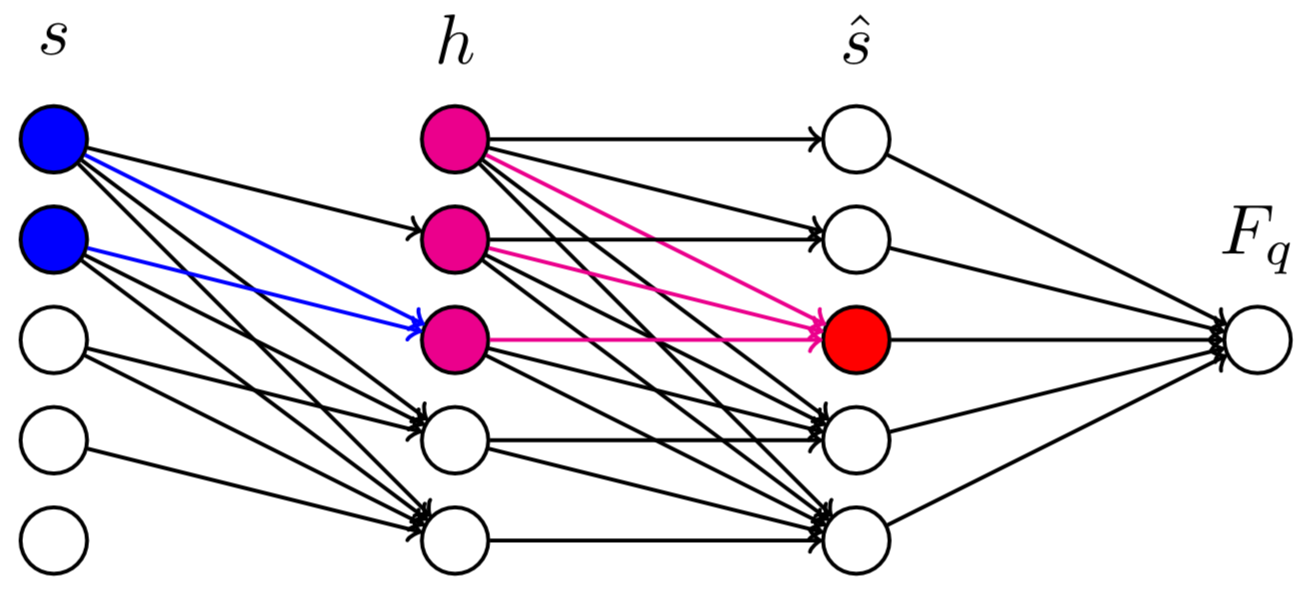

In [14]:
#
from netket import nn as nknn

def autoreg_net(layers, x):
    """
    Return the vector of log probabilities for a Autoregressive network
    with layers, given the inputs.
    
    Assumes input has 3 dimensions
    """
    # apply the layers and selu nonlinearity after every layer
    # except the last
    for (i,layer) in enumerate(layers):
        x = layer(x)
        if i != len(layers)-1:
            x = jax.nn.selu(x)
        
    # reshape the output
    x = x.reshape((x.shape[0], -1, x.shape[-1]))
    log_probs = x - jax.scipy.special.logsumexp(
        x, axis=-1, keepdims=True
    )
    return log_probs


class AutoReg(nn.Module):
    
    def setup(self):
        self.layers = [nknn.MaskedDense1D(features=1, exclusive=True), 
                        nknn.MaskedDense1D(features=2, exclusive=False)]

    def conditionals(self, inputs, index):
        """
        This function compute the conditional probabilities p_i(x_i|x_{i-1}...)
        given a batch of inputs (x) and the indices (i).
        """
        # Make sure the inputs have 3 dimensions
        # by adding the batch dimension and the last feature dimension
        if inputs.ndim == 1:
            inputs = jnp.expand_dims(inputs, axis=0)
        x = jnp.expand_dims(inputs, axis=-1)
        # now x is a 3d tensor
        
        # Compute all the log probabilities.
        # This is a (batch, n_pixels, n_possible_outcomes) vector
        log_probs = autoreg_net(self.layers, x)
        
        # Exponentiate the log-probabilities to get probabilities
        probs = jnp.exp(log_probs)
        
        # Return the probability distribution for a specific pixel
        return probs[:, index, :]

    
    def __call__(self, inputs):
        if inputs.ndim == 1:
            inputs = jnp.expand_dims(inputs, axis=0)

        inputs = jnp.expand_dims(inputs, axis=-1)
        # Convert the input floating-point(0,1) to an integer
        # so it can be used to index the probability distribution
        idx = jnp.array(inputs, dtype=jnp.int32)

        # Compute all the log probabilities.
        # This is a (batch, n_pixels, n_possible_outcomes) vector
        log_probs = autoreg_net(self.layers, inputs)

        # Of the computed log-probabilties, take the one corresponding
        # to the input at every pixel
        log_probs = jnp.take_along_axis(log_probs, idx, axis=-1)
        # Sum over all pixels
        return log_probs.reshape((inputs.shape[0], -1)).sum(axis=1)

model = AutoReg()

Let's try to inspect the structure of the parameters of this network

In [15]:
# rng to generate the initial parameters
key = jax.random.PRNGKey(0)
# example sample. Must be 2d
sa = jnp.ones((1,28*28))
# Initialize the model.
# We want to jit it to speed it up.
pars = jax.jit(model.init)(key, sa)['params']

## 2 - Define autoregressive-sampling algorithm

To sample the autoregressive network we need to generate the probability distribution of the first pixel $p_1(x)$ and then sample $x_1$, then generate the second probability distribution $p_2(x|x_1)$ and sample $x_2$, etcetera.

To do this we will be using a loop.
However, loops in Jax are *ugly* (as hell). 
Not even the devil himself would inflict such pain to his minions.

A loop in jax is defined by passing the function executing the body to `jax.lax.scan`
```python
def scan(f, init, xs, length):
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

In [16]:
def batch_choice(key, a, p):
    """
    Batched version of `jax.random.choice`.
    Attributes:
      key: a PRNGKey used as the random key.
      a: 1D array. Random samples are generated from its elements.
      p: 2D array of shape `(batch_size, a.size)`. Each slice `p[i, :]` is
        the probabilities associated with entries in `a` to generate a sample
        at the index `i` of the output. Can be unnormalized.
    Returns:
      The generated samples as an 1D array of shape `(batch_size,)`.
    """
    p_cumsum = p.cumsum(axis=1)
    r = p_cumsum[:, -1:] * jax.random.uniform(key, shape=(p.shape[0], 1))
    indices = (r > p_cumsum).sum(axis=1)
    out = a[indices]
    return out

In [17]:
from functools import partial

@partial(jax.jit, static_argnums=(2))
def sample_images(key, params, n_samples):
    """
    Sample images from an autoregressive model
    """
    # Total number of pixels in the image
    size = 28*28 
    
    # body of the while loop
    # carry is the state that is carried along at every iteration
    # index is some variable that is given to every iteration
    def scan_fun(carry, index):
        # unpack the carry into the state and the rng key.
        σ, key = carry
        
        # Split the rng key so that we use a key in this iteration
        # and we propagate the other one to the next iteration.
        new_key, key = jax.random.split(key)

        # evaluate model.conditionals to get all the conditional
        # probabilities.
        p = model.apply(
            {'params': params},
            σ,
            index,
            method=model.conditionals,
        )
        
        # List of possible states x_i sampled at every pixel
        possible_values = jnp.array([0, 1], dtype=jnp.int32)
        # new configuration: sample the probability distribution
        new_σ = batch_choice(key, possible_values, p)
        # and set the sampled pixel with the sampled value.
        σ = σ.at[:, index].set(new_σ)

        return (σ, new_key), None

    new_key, key_init, key_scan = jax.random.split(key, 3)

    # We just need a buffer for `σ` before generating each sample
    # The result does not depend on the initial contents in it
    σ = jnp.zeros(
        (n_samples, size),
        dtype=float,
    )
    
    indices = jnp.arange(size)
    (σ, _), _ = jax.lax.scan(scan_fun, (σ, key_scan), indices)

    return σ



Ok, that was hardcore and though.

Let's try to relax a bit by seeing if (hopefully) it works...

(4, 784)


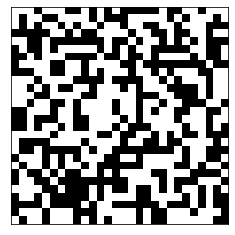

In [18]:
_img = sample_images(key, pars, 4)
print(_img.shape)

vae_utils.show_img(_img.reshape(-1,28,28,1)[0])

yay!!!

In [19]:
from functools import partial

@partial(jax.jit, static_argnums=(2))
def sample_partial_image(key, params, n_samples, initial_images):
    """
    Sample the missing part of an image.
    
    Similar to sample_image but performs fewer iterations, and starts from an initial state.
    """
    size = 28*28 
    n_images = initial_images.shape[0]
    initial_size = initial_images.shape[1]
    
    def scan_fun(carry, index):
        σ, key = carry
        
        new_key, key = jax.random.split(key)

        p = model.apply(
            {'params': params},
            σ,
            index,
            method=model.conditionals,
        )
        
        possible_values = jnp.array([0, 1], dtype=jnp.int32)
        new_σ = batch_choice(key, possible_values, p)
        σ = σ.at[:, index].set(new_σ)

        return (σ, new_key), None

    new_key, key_init, key_scan = jax.random.split(key, 3)

    # We just need a buffer for `σ` before generating each sample
    # The result does not depend on the initial contents in it
    σ = jnp.zeros(
        (n_samples, n_images, size),
        dtype=float,
    )
    # We set the known part of the image
    σ = σ.at[:,:,:initial_size].set(initial_images.reshape(1,n_images, initial_size))
    σ = σ.reshape(-1, size)
    
    # we perform fewer iterations.
    indices = jnp.arange(initial_size, size)
    (σ, _), _ = jax.lax.scan(scan_fun, (σ, key_scan), indices)

    return σ

## 3 - Define the Loss function

In [20]:
def cross_entropy(params, x):
    """
    cross-entropy loss function.
    We compute the mean of log-probabilities of the model
    computed over the inputs sampled from the target distribution.
    """
    p_x = model.apply({"params": params}, x)
    return -jnp.mean(p_x)

def compute_metrics(params, x):
    """
    Compute the metrics to monitor training.
    """
    ce_loss = cross_entropy(params, x).mean()
    return {
      'ce': ce_loss,
    }

## 4 - Prepare the training data

In [21]:
# Parameter: batch size
batch_size = 128

In [22]:
def prepare_image(x):
    """
    function used to process the training data loaded from tensorflow dataset
    """
    # convert to float
    x = tf.cast(x['image'], tf.float32)
    # reshape to concatenate x,y dimensions
    x = tf.reshape(x, (-1,))
    # binarize the data
    x = x >= 0.5
    return x

# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], 'GPU')

rng = random.PRNGKey(0)
rng, key = random.split(rng)

ds_builder = tfds.builder('binarized_mnist')
ds_builder.download_and_prepare()
train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.cache()
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.batch(batch_size)
train_ds = iter(tfds.as_numpy(train_ds))

test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
test_ds = test_ds.map(prepare_image).batch(10000)
test_ds = np.array(list(test_ds)[0])
test_ds = jax.device_put(test_ds)


## 5 - Setup the training step

In [26]:
@jax.jit
def train_step(state, batch, z_rng):
    """
    Takes a mini-batch of data, computes the gradient of the
    loss function and updates the parameters accordingly.
    
    Returns the new state and the value of the loss function
    """
    # We fix the batch data as we only want to compute
    # the gradient w.r.t. the parameters and not the input
    # images
    def loss_fn(params):
        return cross_entropy(params, batch)
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    return loss, state.apply_gradients(grads=grads)

@jax.jit
def evaluate_observables(params, images, rng):
    """
    Evaluate some 'observables' that we track during training.
    
    This function returns three things:
     - metrics: a dictionary of scalar metrics computed on the 
        test dataset provided.
     - generated_images: a 4-tensor of shape (N,28,28,1) containing
        N images generated by the model with no input using the rng
        key provided.
     - reconstructed_images: takes the input images, blanks the bottom half
         and tries to reconstruct the other half of the image.
    """

    metrics = compute_metrics(params, images)
    
    generated_images = sample_images(rng, params, 8*8)
    generated_images = generated_images.reshape(-1, 28, 28, 1)
    
    nreco = 8
    reconstructed_images = sample_partial_image(rng, params, 1, images[:nreco,:28*14])
    reconstructed_images = reconstructed_images.reshape(-1, 28, 28, 1)

    reconstructed_images = jnp.concatenate([images[:nreco].reshape(-1, 28, 28, 1),
                                  reconstructed_images[:nreco].reshape(-1, 28, 28, 1)])

    return metrics, generated_images, reconstructed_images

## 6 - Run the optimisation

In [27]:
num_epochs = 30

max_steps_per_epoch = 120

In [28]:
# Let's pick an optimiser
learning_rate = 0.0005
momentum = 0.9

optimiser = optax.sgd(learning_rate, momentum)

In [33]:
# generate some mock data to initialize the model
init_data = jnp.ones((batch_size, 784), jnp.float32)

# Create a key
seed = 1234
rng, eval_rng, init_rng = random.split(jax.random.PRNGKey(seed), 3)

# Create the training state
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(init_rng, init_data)['params'],
    tx=optimiser,
)

# Create the directory to save output data
import os
os.makedirs("results", exist_ok=True)

In [34]:
steps_per_epoch = 50000 // batch_size

# Print the metrics at step 0
epoch = 0
metrics, generate_images, reconstructed_images = evaluate_observables(state.params, test_ds, eval_rng)
vae_utils.save_image(
    generate_images, f'results/generated_{epoch}.png', nrow=8)
vae_utils.save_image(reconstructed_images, f'results/reconstructed_{epoch}.png', nrow=8)


# training loop

with tqdm(range(1, num_epochs+1)) as pbar:
    for epoch in pbar:

        # iterate the substeps
        for _ in range(min(max_steps_per_epoch, steps_per_epoch)):
            batch = next(train_ds)
            rng, key = random.split(rng)
            _, state = train_step(state, batch, key)

        metrics, generate_images, reconstructed_images = evaluate_observables(state.params, test_ds, eval_rng)
        vae_utils.save_image(
            generate_images, f'results/generated_{epoch}.png', nrow=8)
        vae_utils.save_image(reconstructed_images, f'results/reconstructed_{epoch}.png', nrow=8)

        pbar.write('eval epoch: {}, ce: {:.4f}'.format(
              epoch + 1, metrics['ce']
          ))


  0%|          | 0/30 [00:00<?, ?it/s]

eval epoch: 2, ce: 204.6822
eval epoch: 3, ce: 180.3742
eval epoch: 4, ce: 168.4375
eval epoch: 5, ce: 159.9819
eval epoch: 6, ce: 153.5698
eval epoch: 7, ce: 148.3602
eval epoch: 8, ce: 144.0243
eval epoch: 9, ce: 140.4992
eval epoch: 10, ce: 137.4699
eval epoch: 11, ce: 134.9069
eval epoch: 12, ce: 132.6398
eval epoch: 13, ce: 130.7143
eval epoch: 14, ce: 128.9702
eval epoch: 15, ce: 127.4851
eval epoch: 16, ce: 126.1298
eval epoch: 17, ce: 124.9020
eval epoch: 18, ce: 123.7506
eval epoch: 19, ce: 122.8824
eval epoch: 20, ce: 121.9004
eval epoch: 21, ce: 121.0911
eval epoch: 22, ce: 120.2303
eval epoch: 23, ce: 119.5760
eval epoch: 24, ce: 118.9006
eval epoch: 25, ce: 118.2403
eval epoch: 26, ce: 117.6451
eval epoch: 27, ce: 117.0976
eval epoch: 28, ce: 116.5491
eval epoch: 29, ce: 116.0751
eval epoch: 30, ce: 115.5586
eval epoch: 31, ce: 115.0812
